# Introduction

This is the introduction.

In [3]:
%matplotlib inline
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import astropy.units as u

from poliastro import ephem, iod, twobody, util
from poliastro import plotting
from poliastro.constants import k_Sun

ImportError: cannot import name 'ephem'

In [5]:
# Initial data
N = 50

date_launch = datetime(2011, 11, 26, 15, 2)
date_arrival = datetime(2012, 8, 6, 5, 17)
tof = (date_arrival - date_launch).total_seconds() * u.s

tof.to(u.h)

<Quantity 6086.25 h>

In [4]:
# Calculate Julian days
jd_launch = ephem.jd(date_launch)
jd_arrival = ephem.jd(date_arrival)
jd_vec = np.linspace(jd_launch, jd_arrival, num=N)

In [5]:
# Compute position of the planets in time
coe_earth = ephem.mean_elements(jd_vec, ephem.EARTH)
coe_mars = ephem.mean_elements(jd_vec, ephem.MARS)

rr_earth, vv_earth = twobody.coe2rv(k_Sun, *coe_earth.T)
rr_mars, vv_mars = twobody.coe2rv(k_Sun, *coe_mars.T)

In [6]:
# Compute the transfer orbit!
r0 = rr_earth[0]
rf = rr_mars[-1]

va, vb = iod.lambert(k_Sun, r0, rf, tof)  # Lots of math happening here

coe0_trans = twobody.rv2coe(k_Sun, r0, va)
coef_trans = twobody.rv2coe(k_Sun, rf, vb)

In [7]:
# Extract whole orbit of Earth, Mars and transfer (for plotting)
# New syntax on Python 3: extended iterable unpacking. Very cool!
# http://www.python.org/dev/peps/pep-3132/
*_, nu0_trans = coe0_trans
*_, nuf_trans = coef_trans
rr_trans, _ = twobody.coe2rv(k_Sun, *coe0_trans[:-1], nu=np.linspace(*util.direct_angles(nu0_trans, nuf_trans), num=N))

*_, nu0_earth = coe_earth[0]
*_, nuf_earth = coe_earth[-1]
*_, nu0_mars = coe_mars[0]
*_, nuf_mars = coe_mars[-1]
rr_earth_rest, _ = twobody.coe2rv(k_Sun, *coe_earth.T[:-1], nu=np.linspace(*util.direct_angles(nuf_earth, nu0_earth), num=N))
rr_mars_rest, _ = twobody.coe2rv(k_Sun, *coe_mars.T[:-1], nu=np.linspace(*util.direct_angles(nuf_mars, nu0_mars), num=N))

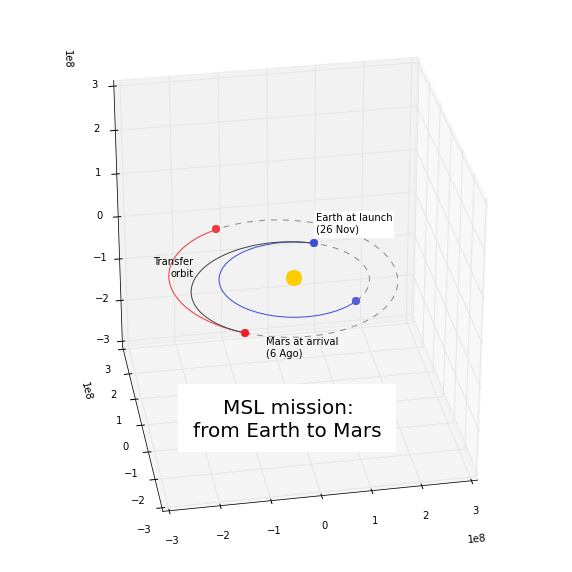

In [8]:
# Plot figure
# To add arrows:
# https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/streamplot.py#L140
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

def plot_body(ax, r, color, size, border=False, **kwargs):
    """Plots body in axes object.

    """
    return ax.plot(*r[:, None], marker='o', color=color, ms=size, mew=int(border), **kwargs)

# I like color
color_earth0 = '#3d4cd5'
color_earthf = '#525fd5'
color_mars0 = '#ec3941'
color_marsf = '#ec1f28'
color_sun = '#ffcc00'
color_orbit = '#888888'
color_trans = '#444444'

# Plotting orbits is easy!
ax.plot(*rr_earth.T, c=color_earth0)
ax.plot(*rr_mars.T, c=color_mars0)
ax.plot(*rr_trans.T, c=color_trans)

ax.plot(*rr_earth_rest.T, ls='--', c=color_orbit)
ax.plot(*rr_mars_rest.T, ls='--', c=color_orbit)

# But plotting plantes feels even magical!
plot_body(ax, np.zeros(3), color_sun, 16)

plot_body(ax, r0, color_earth0, 8)
plot_body(ax, rr_earth[-1], color_earthf, 8)

plot_body(ax, rr_mars[0], color_mars0, 8)
plot_body(ax, rf, color_marsf, 8)

# Add some text
ax.text(-0.75e8, -3.5e8, -1e8, "MSL mission:\nfrom Earth to Mars", size=20, ha='center', va='center', bbox={"pad": 30, "lw": 0, "fc": "w"})
ax.text(r0[0] * 1.15, r0[1] * 1.25, r0[2] * 10, "Earth at launch\n(26 Nov)", ha="left", va="bottom", backgroundcolor='#ffffff')
ax.text(rf[0] * 0.7, rf[1] * 1.1, rf[2], "Mars at arrival\n(6 Ago)", ha="left", va="top")
ax.text(-1.9e8, 8e7, 0, "Transfer\norbit", ha="right", va="center")

# Tune axes
ax.set_xlim(-3e8, 3e8)
ax.set_ylim(-3e8, 3e8)
ax.set_zlim(-3e8, 3e8)

# And finally!
ax.view_init(30, 260)
fig.savefig("trans_30_260.png", bbox_inches='tight')

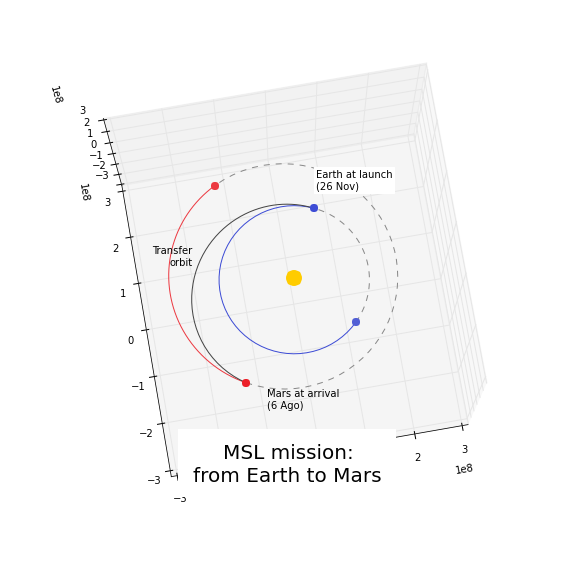

In [9]:
ax.view_init(80, 260)
display(fig)